In [1]:
import pickle

def load_and_preview_features(file_path, dataset_name, print_limit=5):
    """
    加载并预览特征数据，只打印正负中性标签的前若干条。
    返回所有数据（未截断）。
    """
    with open(file_path, 'rb') as file:
        features = pickle.load(file)

    print(f"\n--- {dataset_name.upper()} DATASET ---")

    count = 0
    for i, item in enumerate(features):
        label = item.get('label', 'N/A')
        if label not in ['Positive', 'Negative', 'Neutral']:
            continue

        if count < print_limit:
            video_id = item.get('video_id', 'N/A')
            clip_id = item.get('clip_id', 'N/A')
            label_1 = item.get('label_1', 'N/A')
            mode = item.get('mode', 'N/A')
            text = item.get('text', 'N/A')
            text_feature_shape = item['text_feature'].shape if 'text_feature' in item else 'N/A'
            audio_feature_shape = item['audio_feature'].shape if 'audio_feature' in item else 'N/A'
            #vision_feature_shape = item['vision_features'].shape if 'vision_features' in item else 'N/A'
            vision_feature_shape1 = item['vision_feature_resnet'].shape if 'vision_feature_resnet' in item else 'N/A'

            print(f"Item {i}:")
            print(f"  video_id: {video_id}")
            print(f"  clip_id: {clip_id}")
            print(f"  label_1: {label_1}")
            print(f"  label: {label}")
            print(f"  mode: {mode}")
            print(f"  text: {text}")
            print(f"  text_feature_shape: {text_feature_shape}")
            print(f"  audio_feature_shape: {audio_feature_shape}")
            #print(f"  vision_feature_shape (DenseNet): {vision_feature_shape}")
            print(f"  vision_feature_shape (ResNet): {vision_feature_shape1}")
            print("-" * 50)
            count += 1

    print(f"共加载样本数: {len(features)}（其中三类标签样本展示前 {print_limit} 条）")
    return features

In [2]:
train_features = load_and_preview_features('/root/autodl-tmp/train_features.pkl', 'train')
valid_features = load_and_preview_features('/root/autodl-tmp/valid_features.pkl', 'valid')
test_features = load_and_preview_features('/root/autodl-tmp/test_features.pkl', 'test')


--- TRAIN DATASET ---
Item 0:
  video_id: -3g5yACwYnA
  clip_id: 10
  label_1: 1.0
  label: Positive
  mode: train
  text: N/A
  text_feature_shape: (1, 50, 768)
  audio_feature_shape: torch.Size([1, 1284, 1024])
  vision_feature_shape (ResNet): (25, 2048)
--------------------------------------------------
Item 1:
  video_id: -3g5yACwYnA
  clip_id: 13
  label_1: 0.6666666865348816
  label: Positive
  mode: train
  text: N/A
  text_feature_shape: (1, 19, 768)
  audio_feature_shape: torch.Size([1, 438, 1024])
  vision_feature_shape (ResNet): (8, 2048)
--------------------------------------------------
Item 2:
  video_id: -3g5yACwYnA
  clip_id: 3
  label_1: 0.0
  label: Neutral
  mode: train
  text: N/A
  text_feature_shape: (1, 40, 768)
  audio_feature_shape: torch.Size([1, 963, 1024])
  vision_feature_shape (ResNet): (19, 2048)
--------------------------------------------------
Item 3:
  video_id: -3g5yACwYnA
  clip_id: 2
  label_1: 0.0
  label: Neutral
  mode: train
  text: N/A
  text

In [3]:
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# 假设 features 已经加载并包含在内
train_data = [item for item in train_features if item['mode'] == 'train' and item['label'] in ['Positive', 'Negative']]
valid_data = [item for item in valid_features if item['mode'] == 'valid' and item['label'] in ['Positive', 'Negative']]
test_data = [item for item in test_features if item['mode'] == 'test' and item['label'] in ['Positive', 'Negative']]

In [4]:
del train_features, valid_features, test_features

In [5]:
train_y = np.array([item['label'] for item in train_data])
valid_y = np.array([item['label'] for item in valid_data])
test_y = np.array([item['label'] for item in test_data])

train_X_text = [item['text_feature'] for item in train_data]
valid_X_text = [item['text_feature'] for item in valid_data]
test_X_text = [item['text_feature'] for item in test_data]

train_X_audio = [item['audio_feature'] for item in train_data]
valid_X_audio = [item['audio_feature'] for item in valid_data]
test_X_audio = [item['audio_feature'] for item in test_data]

train_X_vision = [item['vision_feature_resnet'] for item in train_data]
valid_X_vision = [item['vision_feature_resnet'] for item in valid_data]
test_X_vision = [item['vision_feature_resnet'] for item in test_data]

# 打印示例以验证标签转换
print("Sample converted labels (train):", train_y[:10])
print("Sample converted labels (valid):", valid_y[:10])
print("Sample converted labels (test):", test_y[:10])

Sample converted labels (train): ['Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Negative' 'Positive' 'Negative' 'Negative']
Sample converted labels (valid): ['Positive' 'Negative' 'Positive' 'Negative' 'Positive' 'Negative'
 'Negative' 'Negative' 'Positive' 'Positive']
Sample converted labels (test): ['Positive' 'Negative' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Negative' 'Positive' 'Positive']


In [6]:
del train_data, valid_data, test_data

In [7]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
# 初始化标签编码器
label_encoder = LabelEncoder()

# 对训练标签进行拟合并转换
train_Y = label_encoder.fit_transform(train_y)

# 使用相同的编码器来转换验证标签
valid_Y = label_encoder.transform(valid_y)

test_Y = label_encoder.transform(test_y)

In [8]:
import torch

# 将所有特征数据放入一个字典中
text_features = {
    'train_audio': train_X_audio,
    'valid_audio': valid_X_audio,
    'test_audio': test_X_audio
}

# 遍历字典，转换为tensor并去掉维度，然后打印形状
for key, features in text_features.items():
    for i, feature in enumerate(features):
        tensor_feature = torch.tensor(feature)  # 将特征转换为tensor
        tensor_feature = tensor_feature.squeeze(0)  # 去掉大小为1的维度（假设是第一个维度）
        text_features[key][i] = tensor_feature  # 更新字典中的值
        print(f"Feature in {key} at index {i} has shape: {tensor_feature.shape}")

/tmp/ipykernel_1893/2523887850.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_feature = torch.tensor(feature)  # 将特征转换为tensor


Feature in train_audio at index 0 has shape: torch.Size([1284, 1024])
Feature in train_audio at index 1 has shape: torch.Size([438, 1024])
Feature in train_audio at index 2 has shape: torch.Size([821, 1024])
Feature in train_audio at index 3 has shape: torch.Size([811, 1024])
Feature in train_audio at index 4 has shape: torch.Size([464, 1024])
Feature in train_audio at index 5 has shape: torch.Size([591, 1024])
Feature in train_audio at index 6 has shape: torch.Size([573, 1024])
Feature in train_audio at index 7 has shape: torch.Size([366, 1024])
Feature in train_audio at index 8 has shape: torch.Size([573, 1024])
Feature in train_audio at index 9 has shape: torch.Size([668, 1024])
Feature in train_audio at index 10 has shape: torch.Size([433, 1024])
Feature in train_audio at index 11 has shape: torch.Size([571, 1024])
Feature in train_audio at index 12 has shape: torch.Size([458, 1024])
Feature in train_audio at index 13 has shape: torch.Size([455, 1024])
Feature in train_audio at ind

In [9]:
import torch

# 将所有特征数据放入一个字典中
text_features = {
    'train_text': train_X_text,
    'valid_text': valid_X_text,
    'test_text': test_X_text
}

# 遍历字典，转换为tensor并去掉维度，然后打印形状
for key, features in text_features.items():
    for i, feature in enumerate(features):
        tensor_feature = torch.tensor(feature)  # 将特征转换为tensor
        tensor_feature = tensor_feature.squeeze(0)  # 去掉大小为1的维度（假设是第一个维度）
        text_features[key][i] = tensor_feature  # 更新字典中的值
        print(f"Feature in {key} at index {i} has shape: {tensor_feature.shape}")

Feature in train_text at index 0 has shape: torch.Size([50, 768])
Feature in train_text at index 1 has shape: torch.Size([19, 768])
Feature in train_text at index 2 has shape: torch.Size([41, 768])
Feature in train_text at index 3 has shape: torch.Size([30, 768])
Feature in train_text at index 4 has shape: torch.Size([43, 768])
Feature in train_text at index 5 has shape: torch.Size([22, 768])
Feature in train_text at index 6 has shape: torch.Size([32, 768])
Feature in train_text at index 7 has shape: torch.Size([20, 768])
Feature in train_text at index 8 has shape: torch.Size([12, 768])
Feature in train_text at index 9 has shape: torch.Size([22, 768])
Feature in train_text at index 10 has shape: torch.Size([19, 768])
Feature in train_text at index 11 has shape: torch.Size([25, 768])
Feature in train_text at index 12 has shape: torch.Size([21, 768])
Feature in train_text at index 13 has shape: torch.Size([19, 768])
Feature in train_text at index 14 has shape: torch.Size([35, 768])
Featu

In [10]:
import torch

# 将所有特征数据放入一个字典中
vision_features = {
    'train_vision': train_X_vision,
    'valid_vision': valid_X_vision,
    'test_vision': test_X_vision
}

# 遍历字典，转换为tensor并去掉维度，然后打印形状
for key, features in vision_features.items():
    for i, feature in enumerate(features):
        tensor_feature = torch.tensor(feature)  # 将特征转换为tensor
        vision_features[key][i] = tensor_feature  # 更新字典中的值
        print(f"Feature in {key} at index {i} has shape: {tensor_feature.shape}")

Feature in train_vision at index 0 has shape: torch.Size([25, 2048])
Feature in train_vision at index 1 has shape: torch.Size([8, 2048])
Feature in train_vision at index 2 has shape: torch.Size([16, 2048])
Feature in train_vision at index 3 has shape: torch.Size([16, 2048])
Feature in train_vision at index 4 has shape: torch.Size([9, 2048])
Feature in train_vision at index 5 has shape: torch.Size([11, 2048])
Feature in train_vision at index 6 has shape: torch.Size([11, 2048])
Feature in train_vision at index 7 has shape: torch.Size([7, 2048])
Feature in train_vision at index 8 has shape: torch.Size([11, 2048])
Feature in train_vision at index 9 has shape: torch.Size([13, 2048])
Feature in train_vision at index 10 has shape: torch.Size([8, 2048])
Feature in train_vision at index 11 has shape: torch.Size([11, 2048])
Feature in train_vision at index 12 has shape: torch.Size([9, 2048])
Feature in train_vision at index 13 has shape: torch.Size([9, 2048])
Feature in train_vision at index 14 

In [11]:
# 将标签转换为张量
train_Y_tensor = torch.tensor(train_Y)
valid_Y_tensor = torch.tensor(valid_Y)
test_Y_tensor = torch.tensor(test_Y)

In [12]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence

class ThreeModal_Dataset(Dataset):
    def __init__(self, text_features, audio_features,vision_features, labels):
        self.text_features = text_features
        self.audio_features = audio_features
        self.vision_features = vision_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text_features = self.text_features[idx]
        audio_features = self.audio_features[idx]
        vision_features = self.vision_features[idx]
        labels = self.labels[idx]
        return text_features, audio_features, vision_features, labels

def collate_fn(batch):
    # 从批次中分离音频特征、文本特征和标签
    text_features, audio_features, vision_features, labels = zip(*batch)
    
    # 将音频特征和文本特征按照批次中最长的序列进行填充
    text_features_padded = pad_sequence(text_features, batch_first=True)    
    audio_features_padded = pad_sequence(audio_features, batch_first=True)
    vision_features_padded = pad_sequence(vision_features, batch_first=True)    
    
    
    # 转换标签为张量
    labels = torch.tensor(labels)

    return text_features_padded, audio_features_padded, vision_features_padded, labels

In [13]:
train_Y_tensor = torch.tensor(train_Y)
valid_Y_tensor = torch.tensor(valid_Y)
test_Y_tensor = torch.tensor(test_Y)

# 创建Dataset实例
train_dataset = ThreeModal_Dataset(train_X_text, train_X_audio, train_X_vision, train_Y_tensor)
valid_dataset = ThreeModal_Dataset(valid_X_text, valid_X_audio, valid_X_vision, valid_Y_tensor)
test_dataset = ThreeModal_Dataset(test_X_text, test_X_audio, test_X_vision, test_Y_tensor)

# 创建DataLoader，使用自定义的collate_fn
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [14]:
del train_X_text, train_X_audio, train_X_vision, valid_X_text, valid_X_audio, valid_X_vision, valid_Y_tensor

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCrossAttentionClassifier(nn.Module):
    def __init__(self, text_dim, audio_dim, vision_dim, hidden_dim, num_heads, dropout_rate=0.1):
        super(SimpleCrossAttentionClassifier, self).__init__()

        self.dropout = nn.Dropout(dropout_rate)

        # 模态投影层
        self.text_to_hidden = nn.Linear(text_dim, hidden_dim)
        self.audio_to_hidden = nn.Linear(audio_dim, hidden_dim)
        self.vision_to_hidden = nn.Linear(vision_dim, hidden_dim)

        # Cross-Attention 模块：audio → text 和 vision → text
        self.cross_attention_audio_text = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout_rate)
        self.cross_attention_vision_text = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout_rate)

        # 分类器：拼接两个 cross attention 的输出后分类
        self.classifier = nn.Linear(hidden_dim * 2, 1)

    def forward(self, audio_features, text_features, vision_features):
        # 线性投影到统一 hidden_dim
        text_hidden = self.text_to_hidden(text_features)       # (B, L, D)
        audio_hidden = self.audio_to_hidden(audio_features)    # (B, L, D)
        vision_hidden = self.vision_to_hidden(vision_features) # (B, L, D)

        # 转换为 (L, B, D) 以适配 nn.MultiheadAttention
        text_hidden_t = text_hidden.permute(1, 0, 2)
        audio_hidden_t = audio_hidden.permute(1, 0, 2)
        vision_hidden_t = vision_hidden.permute(1, 0, 2)

        # Cross-Attention: audio → text
        audio_guided_text, _ = self.cross_attention_audio_text(query=audio_hidden_t, key=text_hidden_t, value=text_hidden_t)
        audio_guided_text = self.dropout(audio_guided_text.permute(1, 0, 2))  # (B, L, D)

        # Cross-Attention: vision → text
        vision_guided_text, _ = self.cross_attention_vision_text(query=vision_hidden_t, key=text_hidden_t, value=text_hidden_t)
        vision_guided_text = self.dropout(vision_guided_text.permute(1, 0, 2))  # (B, L, D)

        # 平均池化 + L2 归一化，用于对比学习
        audio_rep = F.normalize(audio_guided_text.mean(dim=1), p=2, dim=-1)   # (B, D)
        vision_rep = F.normalize(vision_guided_text.mean(dim=1), p=2, dim=-1) # (B, D)

        # InfoNCE 对比损失
        sim_matrix = torch.matmul(audio_rep, vision_rep.T)   # (B, B)
        pos_scores = torch.diag(sim_matrix)
        temperature = 0.07
        sim_matrix /= temperature
        pos_scores /= temperature

        contrastive_loss = -torch.log(
            torch.exp(pos_scores) / torch.exp(sim_matrix).sum(dim=1)
        ).mean()

        # 拼接 cross attention 表征 → 分类器
        fusion = torch.cat([audio_rep, vision_rep], dim=1)  # (B, 2*D)
        logits = self.classifier(fusion)                    # (B, 1)

        return logits, contrastive_loss


Seed set to 10111


New best model saved with accuracy: 0.8755
Epoch 1: Train Loss = 0.0516, Train Acc = 0.8479, Valid Loss = 0.0442, Valid Acc = 0.8755
Epoch 2: Train Loss = 0.0425, Train Acc = 0.8650, Valid Loss = 0.0407, Valid Acc = 0.8741
New best model saved with accuracy: 0.8783
Epoch 3: Train Loss = 0.0397, Train Acc = 0.8705, Valid Loss = 0.0402, Valid Acc = 0.8783
Epoch 4: Train Loss = 0.0381, Train Acc = 0.8728, Valid Loss = 0.0438, Valid Acc = 0.8630
New best model saved with accuracy: 0.8797
Epoch 5: Train Loss = 0.0372, Train Acc = 0.8749, Valid Loss = 0.0395, Valid Acc = 0.8797
Epoch 6: Train Loss = 0.0362, Train Acc = 0.8789, Valid Loss = 0.0401, Valid Acc = 0.8679
Epoch 7: Train Loss = 0.0356, Train Acc = 0.8828, Valid Loss = 0.0402, Valid Acc = 0.8665
Epoch 8: Train Loss = 0.0344, Train Acc = 0.8849, Valid Loss = 0.0399, Valid Acc = 0.8623
Epoch 9: Train Loss = 0.0340, Train Acc = 0.8878, Valid Loss = 0.0393, Valid Acc = 0.8727
Epoch 10: Train Loss = 0.0332, Train Acc = 0.8898, Valid Loss

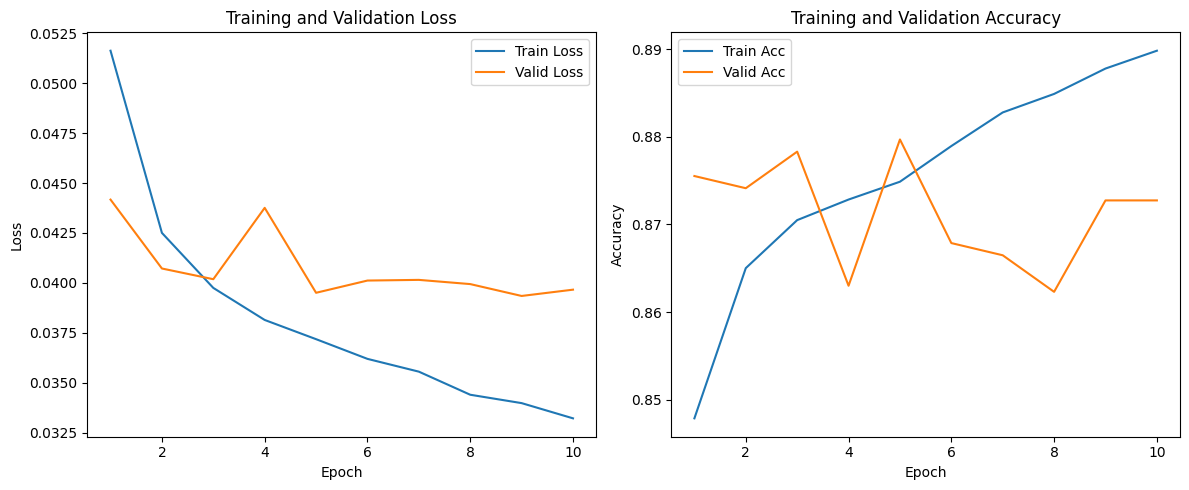

In [26]:
import os
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# ======================== 设置随机种子函数 ========================
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 多卡
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def save_seed(seed, path='seed.txt'):
    with open(path, 'w') as f:
        f.write(str(seed))

def load_seed(path='seed.txt'):
    if os.path.exists(path):
        with open(path, 'r') as f:
            return int(f.read().strip())
    else:
        raise FileNotFoundError(f"Seed file not found at {path}")

# ======================== 初始化设置 ========================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 10111
set_seed(seed)
save_seed(seed)
print(f"Seed set to {seed}")

# ======================== 初始化模型 ========================
model = SimpleCrossAttentionClassifier(
    text_dim=768,
    audio_dim=1024,
    vision_dim=2048,
    hidden_dim=256,
    num_heads=8,
    dropout_rate=0.01
).to(device)

classification_criterion = nn.BCEWithLogitsLoss()
contrastive_weight = 0.0001
optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# ======================== 训练设置 ========================
num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

best_valid_accuracy = 0.0
best_model_path = 'acc-best_model10011.pth'

# ======================== 训练循环 ========================
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_samples = 0, 0, 0

    for audio_features, text_features, vision_features, labels in train_loader:
        audio_features, text_features, vision_features, labels = (
            audio_features.to(device),
            text_features.to(device),
            vision_features.to(device),
            labels.to(device)
        )
        optimizer.zero_grad()

        # ✅ 调整顺序：text_features 第一个
        outputs, contrastive_loss = model(text_features, audio_features, vision_features)
        classification_loss = classification_criterion(outputs.squeeze(), labels.float())
        total_loss = classification_loss + contrastive_weight * contrastive_loss

        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()
        predicted = torch.sigmoid(outputs.squeeze()).round()
        train_correct += (predicted == labels).sum().item()
        train_samples += labels.size(0)

    train_losses.append(train_loss / train_samples)
    train_accuracies.append(train_correct / train_samples)
    scheduler.step()

    # ======================== 验证阶段 ========================
    model.eval()
    valid_loss, valid_correct, valid_samples = 0, 0, 0
    with torch.no_grad():
        for audio_features, text_features, vision_features, labels in valid_loader:
            audio_features, text_features, vision_features, labels = (
                audio_features.to(device),
                text_features.to(device),
                vision_features.to(device),
                labels.to(device)
            )

            # ✅ 调整顺序：text_features 第一个
            outputs, contrastive_loss = model(text_features, audio_features, vision_features)
            classification_loss = classification_criterion(outputs.squeeze(), labels.float())
            total_loss = classification_loss + contrastive_weight * contrastive_loss

            valid_loss += total_loss.item()
            predicted = torch.sigmoid(outputs.squeeze()).round()
            valid_correct += (predicted == labels).sum().item()
            valid_samples += labels.size(0)

    valid_losses.append(valid_loss / valid_samples)
    valid_accuracies.append(valid_correct / valid_samples)

    # 保存最佳模型
    if valid_accuracies[-1] > best_valid_accuracy:
        best_valid_accuracy = valid_accuracies[-1]
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'random_seed': seed
        }, best_model_path)
        print(f"New best model saved with accuracy: {best_valid_accuracy:.4f}")

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Train Acc = {train_accuracies[-1]:.4f}, Valid Loss = {valid_losses[-1]:.4f}, Valid Acc = {valid_accuracies[-1]:.4f}")

# ======================== 可视化 ========================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Acc')
plt.plot(range(1, num_epochs+1), valid_accuracies, label='Valid Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import torch

# 检查是否有可用的 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载最优模型权重
best_model_path = 'acc-best_model10011.pth'  # 注意与训练保存路径一致
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# 初始化标签收集列表
true_labels = []
predicted_labels = []

# 测试推理阶段
with torch.no_grad():
    for audio_features, text_features, vision_features, labels in test_loader:
        audio_features = audio_features.to(device)
        text_features = text_features.to(device)
        vision_features = vision_features.to(device)
        labels = labels.to(device)

        # ✅ 模型调用顺序：text 放在第一位
        outputs, _ = model(text_features, audio_features, vision_features)

        # 二分类预测：Sigmoid + 阈值0.5
        predicted = torch.sigmoid(outputs.squeeze()).round().cpu().numpy()
        predicted_labels.extend(predicted)

        true_labels.extend(labels.cpu().numpy())

# 转为 numpy 数组
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# ======== 指标计算 ========
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='binary')
recall = recall_score(true_labels, predicted_labels, average='binary')
f1 = f1_score(true_labels, predicted_labels, average='binary')
cm = confusion_matrix(true_labels, predicted_labels)

# UA（Unweighted Average）与 WA（Weighted Average）
with np.errstate(divide='ignore', invalid='ignore'):
    per_class_accuracy = np.diag(cm) / np.sum(cm, axis=1)
    per_class_accuracy = np.nan_to_num(per_class_accuracy)
    ua = np.mean(per_class_accuracy)
wa = accuracy  # WA == Accuracy for binary

# ======== 打印结果 ========
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Unweighted Average (UA): {ua:.4f}")
print(f"Weighted Average (WA): {wa:.4f}")
print("\nDetailed classification report:")
print(classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1']))


Accuracy: 0.8676
Precision: 0.8733
Recall: 0.9234
F1 Score: 0.8976
Unweighted Average (UA): 0.8484
Weighted Average (WA): 0.8676

Detailed classification report:
              precision    recall  f1-score   support

     Class 0       0.86      0.77      0.81      1350
     Class 1       0.87      0.92      0.90      2284

    accuracy                           0.87      3634
   macro avg       0.86      0.85      0.86      3634
weighted avg       0.87      0.87      0.87      3634

